# Instructions
So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

# Load and clean

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [13]:
loans_df = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

loans_df.head()
# Note the warning about dtypes.

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,15000.0,15000.0,15000.0,36 months,9.80%,482.61,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,14025.0,14025.0,14025.0,60 months,18.49%,359.90,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,9.80%,643.47,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,15000.0,15000.0,15000.0,60 months,13.44%,344.69,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Check types:

In [14]:
loans_df.dtypes

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

And check our NaNs:

In [15]:
loans_df = loans_df[:-2] # last two rows are all NaNs
loans_df.isnull().sum()

id                                            421095
member_id                                     421095
loan_amnt                                          0
funded_amnt                                        0
funded_amnt_inv                                    0
term                                               0
int_rate                                           0
installment                                        0
grade                                              0
sub_grade                                          0
emp_title                                      23874
emp_length                                     23817
home_ownership                                     0
annual_inc                                         0
verification_status                                0
issue_d                                            0
loan_status                                        0
pymnt_plan                                         0
url                                           

So, we've got a bunch of columns that have way too many nulls to keep as they are.  Since we have 145 features, we can afford to just drop these columns.  After glancing through the numbers above, it looks like 3,000 NaNs will be a good drop threshold for us.

In [16]:
for column in loans_df:
    if loans_df[column].isnull().sum() > 3000:
        loans_df.drop(column, axis=1, inplace=True)

And let's look at the columns that still have significant numbers of NaNs:

In [17]:
for column in loans_df:
    if loans_df[column].isnull().sum() > 30:
        print((column, loans_df[column].isnull().sum()))

('title', 132)
('revol_util', 162)
('last_pymnt_d', 294)


In [18]:
len(loans_df) - len(loans_df.dropna())

599

There are only three remaining columns - but they look like they might be important, especially last payment date.  And if we drop the rows containing all remaining NaNs, we'd only lose 600 rows out of 42,000.  We can live with that.  Let's do it.

In [19]:
loans_df.dropna(inplace=True)

# Solving the dummy-variable-proliferation problem
The initial run of this random forest took a long time (15 minutes) because generating dummy variables from our categorical variables expands our 78 post-cleaning columns to 3205 columns.  This means that one or more of the following must be true:
- some columns that should be quantitative must be getting read as categorical
- there's a string column that's basically unique for each entry

From taking a look at the spreadhseet manually, I can see that there's no unique-string column, so some quantitative column(s) must be getting parsed as categorical.  Manual investigation turns up the following issues:
- PROBLEM: *int_rate* and *revol_util* have a % sign, so they're getting typed as strings and dummied as categoricals. 
- SOLUTION: convert them to floats.
- PROBLEM: *earliest_cr_line* and *last-pymnt-d* and *last_credit_pull_d* are just month-year strings, which are going to generate hundreds of dummy columns.  
- SOLUTION: I should split the date columns into a number for year, and a number for month.  It would also be useful to convert that year to 2015-(year of last credit line) so that it represents a ratio rather than interval variable (capturing how long it's been since their first credit line). 
- PROBLEM: *zip_code* should maybe be dropped - it's a categorical variable with more than a hundred different values.
- SOLUTION: We'll drop the column for now.  If our accuracy scores aren't cutting it, we can consider re-adding.

I'll execute the solutions below, in the order listed above.

In [20]:
print("Column count before conversions: " + str(len(loans_df.columns)))

# convert percentage columns to floats after removing % sign
loans_df["int_rate"] = loans_df.int_rate.str[:-1].astype(float)
loans_df["revol_util"] = loans_df.revol_util.str[:-1].astype(float)

# convert dates to two columns: month and elapsed years
loans_df["earliest_crline_month"] = pd.to_datetime(loans_df.earliest_cr_line).dt.month
loans_df["earliest_crline_yrspast"] = 2015 - pd.to_datetime(loans_df.earliest_cr_line).dt.year

loans_df["last_pymnt_month"] = pd.to_datetime(loans_df.last_pymnt_d).dt.month
loans_df["last_pymnt_yrspast"] = 2015 - pd.to_datetime(loans_df.last_pymnt_d).dt.year

loans_df["last_crpull_month"] = pd.to_datetime(loans_df.last_credit_pull_d).dt.month
loans_df["last_crpull_yrspast"] = 2015 - pd.to_datetime(loans_df.last_credit_pull_d).dt.year

loans_df.drop(["earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"], axis=1, inplace=True)

print("Column count after conversions: " + str(len(loans_df.columns)))

Column count before conversions: 78
Column count after conversions: 81


In [21]:
# drop zip_code
loans_df.drop("zip_code", axis=1, inplace=True)

In [ ]:
# if I need to reload data quickly:
# loans_df = pd.read_csv("loans_cleaned.csv").drop("zip_code", axis=1, inplace=True)

And let's take a look at our target variable values just to see what we're dealing with:

In [22]:
loans_df.loan_status.value_counts()

Fully Paid            202362
Current               145915
Charged Off            64250
Late (31-120 days)      4622
In Grace Period         2039
Late (16-30 days)       1219
Default                   89
Name: loan_status, dtype: int64

Looks good - not terribly skewed, excpet for the small number of defaults.  If we were trying to predict defaults in particular, we'd need to account for that with some weighting (or use a different model, like anomaly detection).

# Feature reduction
Now that the initial dummy-column-proliferation problem is solved, let's take a look at feature importance and see how many unimportant features we can cut without losing too much accuracy.  

A note on feature reduction methods: I think that PCA will be a poor choice of method here because many of the variables are categorical.  Because these work out to be 0-to-1 binary dummy variables, they'll never match the variance of the quantitative variables no matter how important they are.  And of course we can't use PLSR because our target variable is categorical rather than quantitative.  Instead, I'll pull feature importances from the RFC and try a couple possible thresholds for eliminating less significant features.

First let's run the full model with only the small cuts made above:

In [24]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = loans_df.drop('loan_status', axis=1)
Y = loans_df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.98868068, 0.98906116, 0.98848989, 0.98806183, 0.98756243,
       0.98863231, 0.98653951, 0.98259174, 0.98489857, 0.92493935])

Despite dropping the zip_code feature, these results are slightly better than the Thinkful version: the mean and median are slightly higher and the single lower outlier is 0.92 rather than 0.87 in the Thinkful results.  And this runs in about four minutes - a major improvement (the Thinkful version took almost twenty minutes on my machine).

Now let's take a look at our feature importances:

In [25]:
rfc.fit(X, Y)
importances = rfc.feature_importances_
labeled_importances = []
for i in range(len(X.columns)):
    labeled_importances.append( (importances[i], X.columns[i]) )
labeled_importances.sort(reverse=True)
top_5 = [tup[1] for tup in labeled_importances[:5]]
top_10 = [tup[1] for tup in labeled_importances[:10]]
top_20 = [tup[1] for tup in labeled_importances[:20]]
top_30 = [tup[1] for tup in labeled_importances[:30]]
labeled_importances

[(0.29076455625293585, 'out_prncp'),
 (0.10193710525821258, 'out_prncp_inv'),
 (0.09024069715259152, 'recoveries'),
 (0.07434215270064146, 'last_pymnt_yrspast'),
 (0.07283023290074128, 'last_pymnt_amnt'),
 (0.05725146614759506, 'total_rec_prncp'),
 (0.04755720612233652, 'last_pymnt_month'),
 (0.0282492888243283, 'total_pymnt_inv'),
 (0.026140073413638738, 'total_pymnt'),
 (0.019952395352825305, 'last_crpull_month'),
 (0.019706822603131977, 'collection_recovery_fee'),
 (0.0188469905763629, 'total_rec_int'),
 (0.01702381536690044, 'funded_amnt'),
 (0.014235362192846934, 'funded_amnt_inv'),
 (0.012119560441447913, 'loan_amnt'),
 (0.01037101691645996, 'installment'),
 (0.00949502943841387, 'term_ 60 months'),
 (0.007605992123959777, 'last_crpull_yrspast'),
 (0.00689978922114669, 'debt_settlement_flag_Y'),
 (0.006015069950211093, 'debt_settlement_flag_N'),
 (0.004514663573898193, 'term_ 36 months'),
 (0.004382769960719823, 'int_rate'),
 (0.004302538869627818, 'total_rec_late_fee'),
 (0.0034

From looking at the ordered feature list above, we can see that the most important features in predicting loan status are:
- the amount still unpaid (out_prncp, out_prncp_inv)
- the amount recovered after a chargeoff was declared (loan deemed unlikely to be collected)
- the last amount paid, and how many years ago it was paid
- the total amount paid to date
- the month of the last payment

The highly insignificant features are mostly dummy variables from multi-category columns (such as U.S. state), which get diluted by the dummying.  The zero-significance features are anomalous entries into the title or purpose columns.

Now let's set about our initial goal of reducing our dataset without losing too much accuracy.  We'll try using only the top 1 feature, top 2 features, top 3 features, etc. and see how each raise in number of top features affects our accuracy.

In [ ]:
top_n_features = [1,2,3,4,5,6,8,10,12,14,17,20,25,30]
accuracies = []
# this loop calculates 
for n in top_n_features:
    cols = [tup[1] for tup in labeled_importances[:n]]
    X_temp = X[cols]
    rfc_temp = ensemble.RandomForestClassifier()
    acc = np.mean(cross_val_score(rfc_temp, X_temp, Y, cv=3))
    accuracies.append(round(acc, 3))

In [29]:
print(accuracies)

[0.474, 0.473, 0.464, 0.51, 0.465, 0.761, 0.872, 0.922, 0.945, 0.942, 0.941, 0.98, 0.98, 0.982]


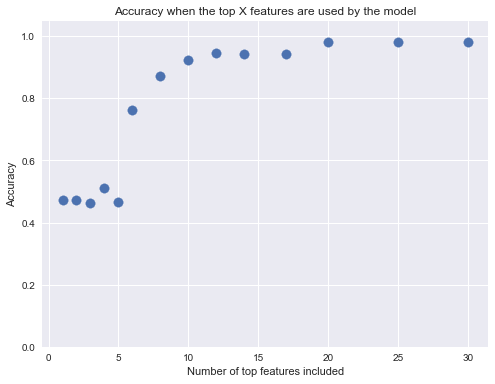

In [42]:
# the above takes a long time to run, so I'll manually copy the values here for reruns:
accuracies_saved = [0.474, 0.473, 0.464, 0.51, 0.465, 0.761, 0.872, 0.922, 0.945, 0.942, 0.941, 0.98, 0.98, 0.982]
top_n_features = [1,2,3,4,5,6,8,10,12,14,17,20,25,30]
plt.figure(figsize=(8,6))
plt.scatter(top_n_features, accuracies_saved, s=90)
plt.title("Accuracy when the top X features are used by the model")
plt.xlabel("Number of top features included")
plt.ylabel("Accuracy")
plt.ylim((0,1.05))
plt.show()

From these results we can draw several conclusions.  First, in answer to the initial prompt: we can reduce the dataset to 10 features and still get 90% accuracy.  Second, the accuracy hits 0.980 with the top 20 features and then proceeds slowly along an asymptote toward the 0.988 maximum accuracy achieved by using the full dataset.  If computational cost is a consideration, I would recommend including only the top 20, as the gains from there onward are very marginal.

Lastly, the prompt asked to see what was possible without using anything to do with the payment amount or outstanding principal, which includes by far the most important feature (out_prncp is three times the importance of the next most important feature) and half of the top 10.  In fact, their cumulative imporance is well over 0.5, which is to say, over half the importance of the entire model.  Well, let's give it a try.

In [38]:
cols = [tup[1] for tup in labeled_importances[:30]]
X_temp = X[cols].copy()
X_temp.drop(['out_prncp', 'out_prncp_inv', 'last_pymnt_amnt', 'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv'], axis=1, inplace=True)
rfc_temp = ensemble.RandomForestClassifier()
acc = np.mean(cross_val_score(rfc_temp, X_temp, Y, cv=3))
print(acc)

0.9057136424178444


It looks like the maximum accuracy we're going to get without the payment amount and outstanding principal features will be around 0.91.  That's shockingly little reduction from 0.98 given that we removed over half of the cumulative feature importance of the last model.  Before drawing conclusions, let's also look at which features this model is placing importance on instead of the ones we removed:

In [39]:
rfc_temp.fit(X_temp, Y)
importances_temp = rfc_temp.feature_importances_
labeled_importances_temp = []
for i in range(len(X_temp.columns)):
    labeled_importances_temp.append( (importances_temp[i], X_temp.columns[i]) )
labeled_importances_temp.sort(reverse=True)
labeled_importances_temp

[(0.234312564514988, 'last_pymnt_yrspast'),
 (0.15210153086896802, 'last_pymnt_month'),
 (0.10339042893632655, 'recoveries'),
 (0.09126657811595706, 'last_crpull_month'),
 (0.055912767173068076, 'collection_recovery_fee'),
 (0.04851746415091897, 'last_crpull_yrspast'),
 (0.04586364316729872, 'total_rec_int'),
 (0.024879472550839794, 'avg_cur_bal'),
 (0.024080196856825282, 'dti'),
 (0.023202202401468294, 'revol_bal'),
 (0.023189910397617162, 'revol_util'),
 (0.022717480797355742, 'int_rate'),
 (0.0219874511420466, 'annual_inc'),
 (0.02001539814072707, 'installment'),
 (0.014362645842426313, 'acc_open_past_24mths'),
 (0.0138220827094685, 'funded_amnt_inv'),
 (0.012767273598151893, 'loan_amnt'),
 (0.012001798508481624, 'funded_amnt'),
 (0.010997348799867471, 'debt_settlement_flag_N'),
 (0.01051382803208684, 'term_ 36 months'),
 (0.010059666278013047, 'debt_settlement_flag_Y'),
 (0.00955375567011702, 'issue_d_Jan-2015'),
 (0.009017291709368658, 'total_rec_late_fee'),
 (0.005467219637613258

Interesting.  My overall takeaway from this is that random forest models are very robust to removing features.  Granted, this effect is partly owed to the cumulative correlation of the remaining features with the missing features.  But such correlation will be present in most large featuresets.  If we look at the new most important variables above, it looks like the model has shifted importance to time features (years since last payment, month of last payment), which will have only a limited correlation with amount features we removed.  This means that the importance shift is mostly a genuine adaptive shift the model has made, rather than directly picking out correlations with the missing features from remaining features.  

Overall, the robustness and adaptation demonstrated here is a very impressive characteristic for this type of model.

# Followup question for Jason:

If I were really trying to optimize performance here, what other random forest parameters should I tweak?  For instance, I could look at a linear regression learning curve and toggle the regularization parameter accordingly, or look at the variable relationships and the residuals distribution to change feature exponents.  But what could I look at here, and what changes would I make in light of what I'd see?